# Assignment 2 - TSP

Dongbo Zhang

dzhang48@gatech.edu

In [2]:
#import mlrose
import mlrose_hiive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
n_experiments = 10
max_attmp = 5000
RANDOM_SEED_LIST = [7, 161117, 15, 123, 7641, 1467, 9052, 1834, 3149, 99]

### Set up problem

In [3]:
from tsp_generator import TSPGenerator
problem = TSPGenerator.generate(seed=RANDOM_SEED_LIST[0],
                                     number_of_cities=25, area_width=250, area_height=250)
output_dir = 'output_tsp'

### Randomized Hill Climbing

In [ ]:
experiment_res_rhc = pd.DataFrame()

restarts = [3] + list(range(5, 31, 5))
interations = 2 ** np.arange(13)

for i, seed in enumerate(RANDOM_SEED_LIST):
    rhc_df = {'exp':[], 'Iteration':[], 'Fitness':[], 'Time':[], 'Restarts':[]}
    for j, r in enumerate(restarts):
        for iter_ in interations:
            start_time = time.process_time()
            best_state_rhc, best_fitness_rhc, cur = mlrose_hiive.random_hill_climb(problem,
                                                                max_attempts=max_attmp,
                                                                restarts=r,
                                                                max_iters = int(iter_),
                                                                curve=False,
                                                                random_state=seed)
            elapse = time.process_time() - start_time
            print ("restart=", r, "seed=", seed, "iter_=", iter_, best_fitness_rhc, elapse)
            rhc_df['exp'].append(i)
            rhc_df['Iteration'].append(iter_)
            rhc_df['Fitness'].append(best_fitness_rhc)
            rhc_df['Time'].append(elapse)
            rhc_df['Restarts'].append(r)
    pd.DataFrame(rhc_df).to_csv('{}/rhc_{}.csv'.format(output_dir,i), index=False)     

### Simulated Annealing

In [ ]:
from mlrose_hiive.runners.sa_runner import SARunner
experiment_res_sa = pd.DataFrame()
for i, seed in enumerate(RANDOM_SEED_LIST):
    experiment_name = 'experiment_sa_{}'.format(i)
    sa = SARunner(problem=problem,
                  experiment_name=experiment_name,
                  output_directory='output_tsp',
                  seed=seed,
                  iteration_list=2 ** np.arange(13),
                  max_attempts=max_attmp,
                  temperature_list=[1, 10, 50, 100, 500, 1000,],
                  decay_list = [mlrose_hiive.GeomDecay, mlrose_hiive.ExpDecay])

    df_run_stats, df_run_curves = sa.run() 
    df_run_stats['exp'] = i
    experiment_res_sa = pd.concat([experiment_res_sa, df_run_stats], axis=0)

### Genetic Algorithm (GA)

In [ ]:
from mlrose_hiive.runners.ga_runner import GARunner
experiment_res_ga = pd.DataFrame()
for i, seed in enumerate(RANDOM_SEED_LIST):
    experiment_name = 'experiment_ga_{}'.format(i)
    ga = GARunner(problem=problem,
                  experiment_name=experiment_name,
                  output_directory="output_tsp",
                  seed=seed,
                  iteration_list=2 ** np.arange(13),
                  max_attempts=5000,
                  population_sizes=[100, 200, 500],
                  mutation_rates=[0.01, 0.1, 0.3])
                  
    df_run_stats, df_run_curves = ga.run() 
    df_run_stats['exp'] = i
    experiment_res_ga = pd.concat([experiment_res_ga, df_run_stats], axis=0)

### MIMIC

In [ ]:
from mlrose_hiive.runners.mimic_runner import MIMICRunner
experiment_res_mimic = pd.DataFrame()
for i, seed in enumerate(RANDOM_SEED_LIST):
    if i >= 6:
        experiment_name = 'experiment_mimic_{}'.format(i)
        mimic = MIMICRunner(problem=problem,
                      experiment_name=experiment_name,
                      output_directory='output_tsp',
                      seed=seed,
                      iteration_list=2 ** np.arange(13),
                      max_attempts=500,
                      population_sizes = [100, 200, 400],
                      keep_percent_list=[0.1, 0.2, 0.5])
                  
        df_run_stats, df_run_curves = mimic.run() 
        df_run_stats['exp'] = i
        experiment_res_mimic = pd.concat([experiment_res_mimic, df_run_stats], axis=0)

### Read results and analysis

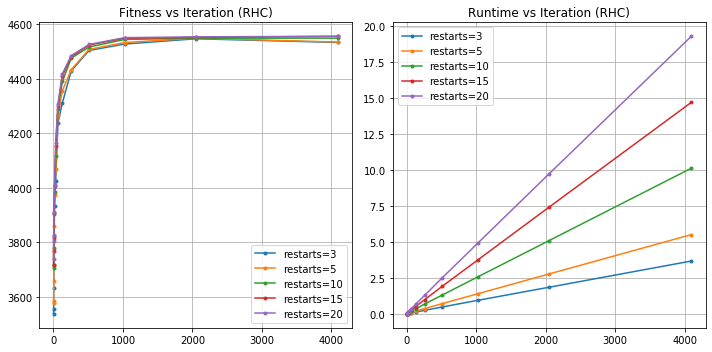

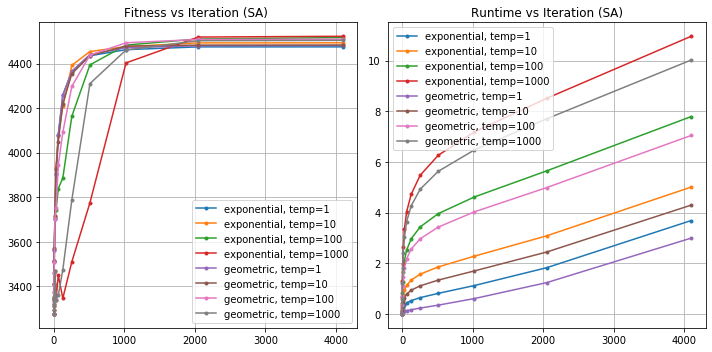

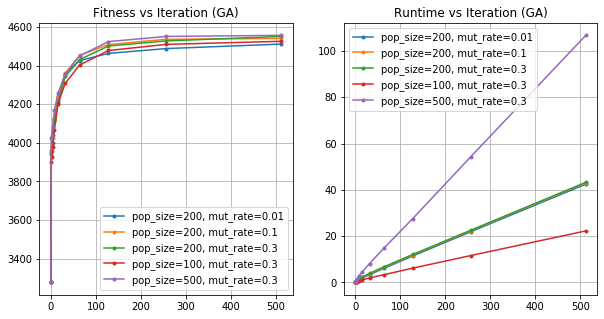

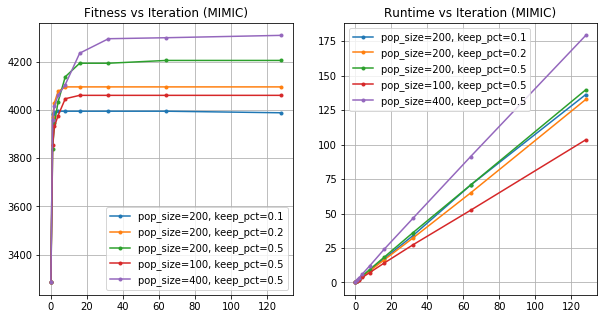

In [4]:
### TSP

def read_res(model_name, exp_name, output_dir, length):
    res = pd.DataFrame()
    for i in range(length):
        file = '{output_dir}/{exp_name}_{i}/{model}__{exp_name}_{i}__run_stats_df.csv'.format(output_dir=output_dir, 
                                                                               exp_name=exp_name, model=model_name,
                                                                                       i=i)
        tmp = pd.read_csv(file)
        res = pd.concat([res, tmp], axis=0)
    return res

def read_res_1(model_name, exp_name, output_dir, length):
    res = pd.DataFrame()
    for i in range(length):                                                                            
        file = '{output_dir}/{model}_{i}.csv'.format(output_dir=output_dir, 
                                                                               exp_name=exp_name, model=model_name,
                                                                                       i=i)
        tmp = pd.read_csv(file)
        res = pd.concat([res, tmp], axis=0)
    return res

output_dir = 'output_tsp'
sa_res_df = read_res('sa','experiment_sa',output_dir,len(RANDOM_SEED_LIST))
sa_res_df_avg = sa_res_df.groupby(['Iteration','schedule_type','Temperature'])[['Fitness','Time']].mean().reset_index()
rhc_res_df = read_res_1('rhc','experiment_rhc',output_dir,len(RANDOM_SEED_LIST))
rhc_res_df_avg = rhc_res_df.groupby(['Iteration','Restarts'])[['Fitness','Time']].mean().reset_index()


output_dir = 'output_tsp1'
ga_res_df = read_res('ga','experiment_ga',output_dir,len(RANDOM_SEED_LIST))
ga_res_df_avg = ga_res_df.groupby(['Iteration','Population Size','Mutation Rate'])[['Fitness','Time']].mean().reset_index()
mimic_res_df = read_res('mimic','experiment_mimic',output_dir,len(RANDOM_SEED_LIST)-1)
mimic_res_df_avg = mimic_res_df.groupby(['Iteration','Population Size','Keep Percent'])[['Fitness','Time']].mean().reset_index()


#### RHC
fig, ax = plt.subplots(1,2, figsize=(10,5))
restarts_values = rhc_res_df_avg['Restarts'].unique()[:-2]
for r in range(0,len(restarts_values)):
    ax[0].plot(rhc_res_df_avg[(rhc_res_df_avg['Restarts']==restarts_values[r])]['Iteration'],
                rhc_res_df_avg[(rhc_res_df_avg['Restarts']==restarts_values[r])]['Fitness'],
                label="restarts={}".format(restarts_values[r]), marker=".")
    ax[1].plot(rhc_res_df_avg[(rhc_res_df_avg['Restarts']==restarts_values[r])]['Iteration'],
                rhc_res_df_avg[(rhc_res_df_avg['Restarts']==restarts_values[r])]['Time'],
                label="restarts={}".format(restarts_values[r]), marker=".")
ax[0].set_title("Fitness vs Iteration (RHC)")
ax[1].set_title("Runtime vs Iteration (RHC)")
ax[0].legend()
ax[1].legend()
ax[0].grid(True)
ax[1].grid(True)
#ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left',
#            borderaxespad=0, frameon=False)
plt.tight_layout()
plt.savefig('tsp_rhc_param.png',dpi=200)
plt.show()

#### SA
fig, ax = plt.subplots(1,2, figsize=(10,5))
temperature = [1, 10, 100, 1000]
for schedule in sa_res_df_avg['schedule_type'].unique():
    for t in temperature:
        ax[0].plot(sa_res_df_avg[(sa_res_df_avg['schedule_type']==schedule)&(sa_res_df_avg['Temperature']==t)]['Iteration'],
                sa_res_df_avg[(sa_res_df_avg['schedule_type']==schedule)&(sa_res_df_avg['Temperature']==t)]['Fitness'],
                label="{}, temp={}".format(schedule, t), marker=".")
        ax[1].plot(sa_res_df_avg[(sa_res_df_avg['schedule_type']==schedule)&(sa_res_df_avg['Temperature']==t)]['Iteration'],
                sa_res_df_avg[(sa_res_df_avg['schedule_type']==schedule)&(sa_res_df_avg['Temperature']==t)]['Time'],
                label="{}, temp={}".format(schedule, t), marker=".")
        
ax[0].set_title("Fitness vs Iteration (SA) ")
ax[1].set_title("Runtime vs Iteration (SA)")
ax[0].legend()
ax[1].legend()

ax[0].grid(True)
ax[1].grid(True)

plt.tight_layout()
plt.savefig('tsp_sa_param.png',dpi=200)
plt.show()

#### GA

ga_res_df_avg = ga_res_df_avg[ga_res_df_avg.Iteration <= 2**9]
fig, ax = plt.subplots(1,2, figsize=(10,5))
ga_params = [(200, 0.01),(200,0.1), (200, 0.3), (100, 0.3), (500, 0.3)]
for pop_size, rate in ga_params:
    ax[0].plot(ga_res_df_avg[(ga_res_df_avg['Population Size']==pop_size)&(ga_res_df_avg['Mutation Rate']==rate)]['Iteration'],
                ga_res_df_avg[(ga_res_df_avg['Population Size']==pop_size)&(ga_res_df_avg['Mutation Rate']==rate)]['Fitness'],
                label="pop_size={}, mut_rate={}".format(pop_size, rate), marker=".")

    ax[1].plot(ga_res_df_avg[(ga_res_df_avg['Population Size']==pop_size)&(ga_res_df_avg['Mutation Rate']==rate)]['Iteration'],
                ga_res_df_avg[(ga_res_df_avg['Population Size']==pop_size)&(ga_res_df_avg['Mutation Rate']==rate)]['Time'],
                label="pop_size={}, mut_rate={}".format(pop_size, rate), marker=".")
    
ax[0].set_title("Fitness vs Iteration (GA)")
ax[1].set_title("Runtime vs Iteration (GA)")
ax[0].legend()
ax[1].legend()

ax[0].grid(True)
ax[1].grid(True)
plt.savefig('tsp_ga_param.png',dpi=200)
plt.show()


#### MIMIC

mimic_params = [(200, 0.1),(200,0.2), (200, 0.5), (100, 0.5), (400,0.5)]
mimic_res_df_avg = mimic_res_df_avg[mimic_res_df_avg.Iteration <= 2**7]
fig, ax = plt.subplots(1,2, figsize=(10,5))
for pop_size, rate in mimic_params:
    ax[0].plot(mimic_res_df_avg[(mimic_res_df_avg['Population Size']==pop_size)&(mimic_res_df_avg['Keep Percent']==rate)]['Iteration'],
                mimic_res_df_avg[(mimic_res_df_avg['Population Size']==pop_size)&(mimic_res_df_avg['Keep Percent']==rate)]['Fitness'],
                label="pop_size={}, keep_pct={}".format(pop_size, rate), marker=".")

    ax[1].plot(mimic_res_df_avg[(mimic_res_df_avg['Population Size']==pop_size)&(mimic_res_df_avg['Keep Percent']==rate)]['Iteration'],
                mimic_res_df_avg[(mimic_res_df_avg['Population Size']==pop_size)&(mimic_res_df_avg['Keep Percent']==rate)]['Time'],
                label="pop_size={}, keep_pct={}".format(pop_size, rate), marker=".")
    
ax[0].set_title("Fitness vs Iteration (MIMIC)")
ax[1].set_title("Runtime vs Iteration (MIMIC)")
ax[0].legend()
ax[1].legend()

ax[0].grid(True)
ax[1].grid(True)


plt.savefig('tsp_mimic_param.png',dpi=200)
plt.show()

### Compare methods

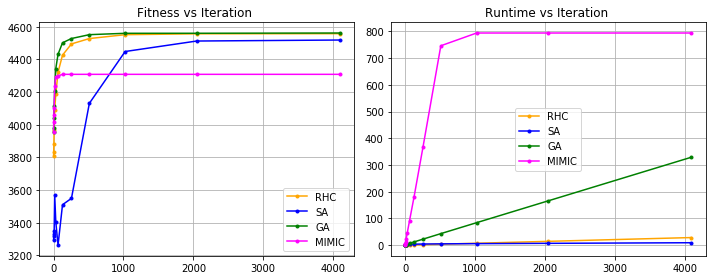

In [5]:
# TSP Comparison
sa_res_df_avg = sa_res_df.groupby(['Iteration','schedule_type','Temperature'])[['Fitness','Time']].mean().reset_index()
ga_res_df_avg = ga_res_df.groupby(['Iteration','Population Size','Mutation Rate'])[['Fitness','Time']].mean().reset_index()
rhc_res_df_avg = rhc_res_df.groupby(['Iteration','Restarts'])[['Fitness','Time']].mean().reset_index()
mimic_res_df_avg = mimic_res_df.groupby(['Iteration','Population Size','Keep Percent'])[['Fitness','Time']].mean().reset_index()




best_rhc = rhc_res_df_avg[rhc_res_df_avg['Restarts']==30].reset_index(drop=False)
best_sa = sa_res_df_avg[(sa_res_df_avg['schedule_type']=='exponential')&
                       (sa_res_df_avg['Temperature']==500)].reset_index(drop=False)
best_ga = ga_res_df_avg[(ga_res_df_avg['Population Size']==200)&
                       (ga_res_df_avg['Mutation Rate']==0.3)].reset_index(drop=False)
best_mimic = mimic_res_df_avg[(mimic_res_df_avg['Population Size']==400)&
                       (mimic_res_df_avg['Keep Percent']==0.5)].reset_index(drop=False)


comparison = pd.merge(best_rhc, best_sa, on='Iteration', suffixes=('_rhc','_sa'))
comparison = pd.merge(comparison, best_ga, on='Iteration')
comparison = comparison.rename(columns={'Fitness':'Fitness_ga', 'Time':'Time_ga'})
comparison = pd.merge(comparison, best_mimic, on='Iteration')
comparison = comparison.rename(columns={'Fitness':'Fitness_mimic', 'Time':'Time_mimic'})
fig, ax = plt.subplots(1,2, figsize=(10,4))

ax[0].plot(comparison['Iteration'], comparison['Fitness_rhc'], label="RHC", marker=".", color='orange')
ax[0].plot(comparison['Iteration'], comparison['Fitness_sa'], label="SA", marker=".", color='blue')
ax[0].plot(comparison['Iteration'], comparison['Fitness_ga'], label="GA", marker=".", color='green')
ax[0].plot(comparison['Iteration'], comparison['Fitness_mimic'], label="MIMIC", marker=".", color='magenta')


ax[1].plot(comparison['Iteration'], comparison['Time_rhc'], label="RHC", marker=".", color='orange')
ax[1].plot(comparison['Iteration'], comparison['Time_sa'], label="SA", marker=".", color='blue')
ax[1].plot(comparison['Iteration'], comparison['Time_ga'], label="GA", marker=".", color='green')
ax[1].plot(comparison['Iteration'], comparison['Time_mimic'], label="MIMIC", marker=".", color='magenta')



ax[0].set_title("Fitness vs Iteration ")
ax[1].set_title("Runtime vs Iteration ")
ax[0].legend()
ax[1].legend()
ax[0].grid(True)
ax[1].grid(True)
#ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left',
#            borderaxespad=0, frameon=False)
plt.tight_layout()
plt.savefig('tsp_comparison1.png',dpi=200)
plt.show()

### Run Algorithms on different sizes

In [ ]:
from mlrose_hiive.runners.sa_runner import SARunner
from mlrose_hiive.runners.ga_runner import GARunner
from mlrose_hiive.runners.mimic_runner import MIMICRunner

for num in range(10, 50, 10):
    problem = TSPGenerator.generate(seed=RANDOM_SEED_LIST[0],
                                     number_of_cities=num, area_width=250, area_height=250)


    print (num)
    output_dir = 'tsp_compare_new_{}'.format(num)
        
    experiment_res_sa = pd.DataFrame()
    for i, seed in enumerate(RANDOM_SEED_LIST):
        experiment_name = 'experiment_sa_{}'.format(i)
        sa = SARunner(problem=problem,
                  experiment_name=experiment_name,
                  output_directory=output_dir,
                  seed=seed,
                  iteration_list=2 ** np.arange(13),
                  max_attempts=max_attmp,
                  temperature_list=[1000],
                  decay_list = [mlrose_hiive.ExpDecay])

        df_run_stats, df_run_curves = sa.run() 
        
        
        rhc_df = {'exp':[], 'Iteration':[], 'Fitness':[], 'Time':[]}
        interations=2 ** np.arange(13)
        for iter_ in interations:
            start_time = time.process_time()
            best_state_rhc, best_fitness_rhc, cur = mlrose_hiive.random_hill_climb(problem,
                                                                max_attempts=max_attmp,
                                                                restarts=15,
                                                                max_iters = int(iter_),
                                                                curve=False,
                                                                random_state=seed)
            elapse = time.process_time() - start_time
            print ( "seed=", seed, "iter_=", iter_, best_fitness_rhc, elapse)
            rhc_df['exp'].append(i)
            rhc_df['Iteration'].append(iter_)
            rhc_df['Fitness'].append(best_fitness_rhc)
            rhc_df['Time'].append(elapse)
        pd.DataFrame(rhc_df).to_csv('{}/rhc_{}.csv'.format(output_dir,i), index=False)
        
        experiment_name = 'experiment_ga_{}'.format(i)
        ga = GARunner(problem=problem,
                  experiment_name=experiment_name,
                  output_directory=output_dir,
                  seed=seed,
                  iteration_list=2 ** np.arange(13),
                  max_attempts=5000,
                  population_sizes=[200],
                  mutation_rates=[0.3])
                  
        df_run_stats, df_run_curves = ga.run() 
        
        
        experiment_name = 'experiment_mimic_{}'.format(i)
        mimic = MIMICRunner(problem=problem,
                      experiment_name=experiment_name,
                      output_directory=output_dir,
                      seed=seed,
                      iteration_list=2 ** np.arange(13),
                      max_attempts=max_attmp/10,
                      population_sizes = [400],
                      keep_percent_list=[0.5])
                  
        df_run_stats, df_run_curves = mimic.run() 
       

### Read results

In [7]:

def read_res(model_name, exp_name, output_dir, length):
    res = pd.DataFrame()
    for i in range(length):
        file = '{output_dir}/{exp_name}_{i}/{model}__{exp_name}_{i}__run_stats_df.csv'.format(output_dir=output_dir, 
                                                                               exp_name=exp_name, model=model_name,
                                                                                       i=i)
        tmp = pd.read_csv(file)
        tmp['exp'] = i
        tmp['num_eval'] = tmp['Iteration'].tolist()[tmp['Fitness'].tolist().index(tmp['Fitness'].max())]
        tmp['Time'] = tmp['Time'].tolist()[tmp['Fitness'].tolist().index(tmp['Fitness'].max())]
        res = pd.concat([res, tmp], axis=0)
    return res

def read_res_1(model_name, exp_name, output_dir, length):
    res = pd.DataFrame()
    for i in range(length):                                                                            
        file = '{output_dir}/{model}_{i}.csv'.format(output_dir=output_dir, 
                                                                               exp_name=exp_name, model=model_name,
                                                                                       i=i)
        tmp = pd.read_csv(file)
        tmp['exp'] = i
        tmp['num_eval'] = tmp['Iteration'].tolist()[tmp['Fitness'].tolist().index(tmp['Fitness'].max())]
        res = pd.concat([res, tmp], axis=0)
    return res

compare_all = pd.DataFrame()
for num in range(10, 50, 10):
    output_dir = 'tsp_compare_new_{}'.format(num)

    sa_res_df = read_res('sa','experiment_sa',output_dir, len(RANDOM_SEED_LIST))
    rhc_res_df = read_res_1('rhc','experiment_rhc',output_dir,len(RANDOM_SEED_LIST))
    ga_res_df = read_res('ga','experiment_ga',output_dir,len(RANDOM_SEED_LIST))
    mimic_res_df = read_res('mimic','experiment_mimic',output_dir,len(RANDOM_SEED_LIST))

    sa_res_df['algo'] = 'sa'
    rhc_res_df['algo'] = 'rhc'
    ga_res_df['algo'] = 'ga'
    mimic_res_df['algo'] = 'mimic'
    sa_res_df_best = sa_res_df.groupby(['algo','exp'])[['Fitness','Time','num_eval']].max().reset_index().groupby('algo').mean().reset_index()
    rhc_res_df_best = rhc_res_df.groupby(['algo','exp'])[['Fitness','Time','num_eval']].max().reset_index().groupby('algo').mean().reset_index()
    ga_res_df_best = ga_res_df.groupby(['algo','exp'])[['Fitness','Time','num_eval']].max().reset_index().groupby('algo').mean().reset_index()
    mimic_res_df_best = mimic_res_df.groupby(['algo','exp'])[['Fitness','Time','num_eval']].max().reset_index().groupby('algo').mean().reset_index()
    
    
    compare = pd.concat([sa_res_df_best[['Fitness','Time','num_eval','algo']],rhc_res_df_best[['Fitness','Time','num_eval','algo']],
                        ga_res_df_best[['Fitness','Time','num_eval','algo']],mimic_res_df_best[['Fitness','Time','num_eval','algo']]],
                       axis=0)
    compare['problem size'] = num
    compare_all = pd.concat([compare_all, compare], axis=0)
    
    



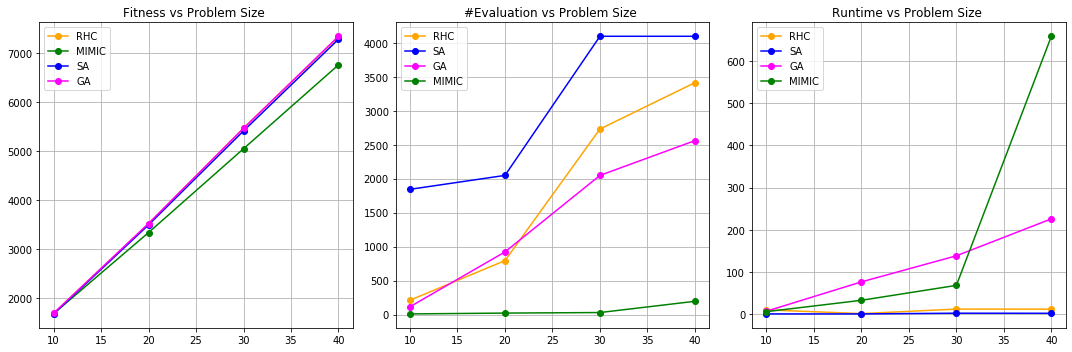

In [10]:
fitness = compare_all.pivot_table(values='Fitness', columns='algo',index='problem size').reset_index()
time_ = compare_all.pivot_table(values='Time', columns='algo',index='problem size').reset_index()
eval_ = compare_all.pivot_table(values='num_eval', columns='algo',index='problem size').reset_index()

fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].plot(fitness['problem size'], fitness['rhc'], label="RHC", marker="o", color='orange')
#ax[0].plot(fitness['problem size'], fitness['sa'], label="SA", marker="o", color='blue')

ax[0].plot(fitness['problem size'], fitness['mimic'], label="MIMIC", marker="o", color='green')
ax[0].plot(fitness['problem size'], fitness['sa'], label="SA", marker="o", color='blue')
ax[0].plot(fitness['problem size'], fitness['ga'], label="GA", marker="o", color='magenta')
ax[1].plot(eval_['problem size'], eval_['rhc'], label="RHC", marker="o", color='orange')
ax[1].plot(eval_['problem size'], eval_['sa'], label="SA", marker="o", color='blue')
ax[1].plot(eval_['problem size'], eval_['ga'], label="GA", marker="o", color='magenta')
ax[1].plot(eval_['problem size'], eval_['mimic'], label="MIMIC", marker="o", color='green')
ax[2].plot(time_['problem size'], time_['rhc'], label="RHC", marker="o", color='orange')
ax[2].plot(time_['problem size'], time_['sa'], label="SA", marker="o", color='blue')
ax[2].plot(time_['problem size'], time_['ga'], label="GA", marker="o", color='magenta')
ax[2].plot(time_['problem size'], time_['mimic'], label="MIMIC", marker="o", color='green')



ax[0].set_title("Fitness vs Problem Size ")
ax[1].set_title("#Evaluation vs Problem Size ")
ax[2].set_title("Runtime vs Problem Size ")
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
#ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left',
#            borderaxespad=0, frameon=False)
plt.tight_layout()
plt.savefig('tsp_compare_all.png',dpi=200)
plt.show()